# Molecular Diffusion with Graph Neural Networks: A DeepChem Tutorial

This notebook demonstrates how to implement molecular diffusion models using Graph Neural Networks (GNNs) with DeepChem data. We'll explore the fundamentals of denoising diffusion probabilistic models (DDPMs) applied to molecular generation.

## Key Concepts:
- **DDPM**: Gradually adds noise to data, then learns to reverse the process
- **GNN Integration**: Uses graph structure of molecules for better representations
- **Molecular Generation**: Creates new drug-like molecules from learned distributions

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
import warnings
import time
from collections import defaultdict
import seaborn as sns

warnings.filterwarnings('ignore')

from diffusion_gnn_2d.data.deepchem import DeepChemMolecularDataset
from diffusion_gnn_2d.models import (
    create_diffusion_model,
    create_molecular_gnn,
    create_noise_scheduler,
    count_parameters,
    MolecularPropertyPredictor
)
from diffusion_gnn_2d.utils.mol_diff_gnn import (
    visualize_molecule,
    plot_training_metrics,
    plot_molecular_properties,
    calculate_molecular_diversity
)

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normalization for NumSpiroAtoms. Feature removed!
No normalization for NumUnspecifiedAtomStereoCenters. Feature removed!
No normalization for Phi. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'dgl'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (/home/jantine/miniconda3/envs/diff_gnn/lib/python3.11/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning depende

Using device: cuda


# Dataset Exploration

In [2]:
# Start with small molecules first
dataset = DeepChemMolecularDataset('tox21', max_atoms=30)

print(f"Dataset: {dataset.dataset_name}")
print(f"Number of molecules: {len(dataset.dataset)}")
print(f"Max atoms allowed: {dataset.max_atoms}")
print(f"Atom feature dimension: {dataset._get_atom_feature_dim()}")
print(f"Bond feature dimension: {dataset._get_bond_feature_dim()}")


INFO:diffusion_gnn_2d.data.deepchem:Loading DeepChem dataset: tox21
INFO:deepchem.data.datasets:Loading dataset from disk.
INFO:deepchem.data.datasets:Loading dataset from disk.
INFO:deepchem.data.datasets:Loading dataset from disk.
INFO:diffusion_gnn_2d.data.deepchem:Loaded tox21 dataset with 6258 molecules


Dataset: tox21
Number of molecules: 6258
Max atoms allowed: 30
Atom feature dimension: 37
Bond feature dimension: 10


In [3]:
# Let's examine some raw SMILES from the dataset
sample_smiles = []
for i in range(10):
    smiles = dataset.dataset.ids[i]
    sample_smiles.append(smiles)
    print(f"{i+1:2d}: {smiles}")

 1: CC(O)(P(=O)(O)O)P(=O)(O)O
 2: CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C
 3: OC[C@H](O)[C@@H](O)[C@H](O)CO
 4: CCCCCCCC(=O)[O-].CCCCCCCC(=O)[O-].[Zn+2]
 5: CC(C)COC(=O)C(C)C
 6: C=C(C)C(=O)OCCOC(=O)C(=C)C
 7: CCCCCCCCCCOCC(O)CN
 8: C#CCO
 9: CC(O)CC(C)(C)O
10: CC(C)(C)CC(C)(C)N


# Molecular Property Analysis

In [4]:
# Analyze molecular properties
def analyze_molecules(smiles_list, max_analyze=1000):
    """Analyze basic molecular properties"""
    properties = {
        'num_atoms': [],
        'num_bonds': [],
        'molecular_weight': [],
        'logp': [],
        'num_rings': [],
        'smiles': []
    }

    valid_count = 0
    for smiles in smiles_list[:max_analyze]:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            properties['num_atoms'].append(mol.GetNumAtoms())
            properties['num_bonds'].append(mol.GetNumBonds())
            properties['molecular_weight'].append(Descriptors.MolWt(mol))
            properties['logp'].append(Descriptors.MolLogP(mol))
            properties['num_rings'].append(Descriptors.RingCount(mol))
            properties['smiles'].append(smiles)
            valid_count += 1

    print(f"Analyzed {valid_count} valid molecules out of {len(smiles_list[:max_analyze])}")
    return pd.DataFrame(properties)


In [5]:
# Analyze the dataset
all_smiles = [dataset.dataset.ids[i] for i in range(len(dataset.dataset))]
mol_df = analyze_molecules(all_smiles, max_analyze=2000)

# Display basic statistics
print("\nMolecular Property Statistics:")
print(mol_df.describe())

[14:52:34] WARNING: not removing hydrogen atom without neighbors


Analyzed 2000 valid molecules out of 2000

Molecular Property Statistics:
         num_atoms    num_bonds  molecular_weight         logp   num_rings
count  2000.000000  2000.000000       2000.000000  2000.000000  2000.00000
mean     11.798000    10.870500        189.812914     1.765332     0.11250
std       6.669215     6.693066        100.286992     2.394732     0.31606
min       1.000000     0.000000          9.012000   -10.036400     0.00000
25%       7.000000     6.000000        122.155250     0.379030     0.00000
50%      10.000000    10.000000        164.831000     1.567650     0.00000
75%      14.000000    13.000000        229.120500     2.956775     0.00000
max      57.000000    56.000000        807.339000    16.428500     1.00000


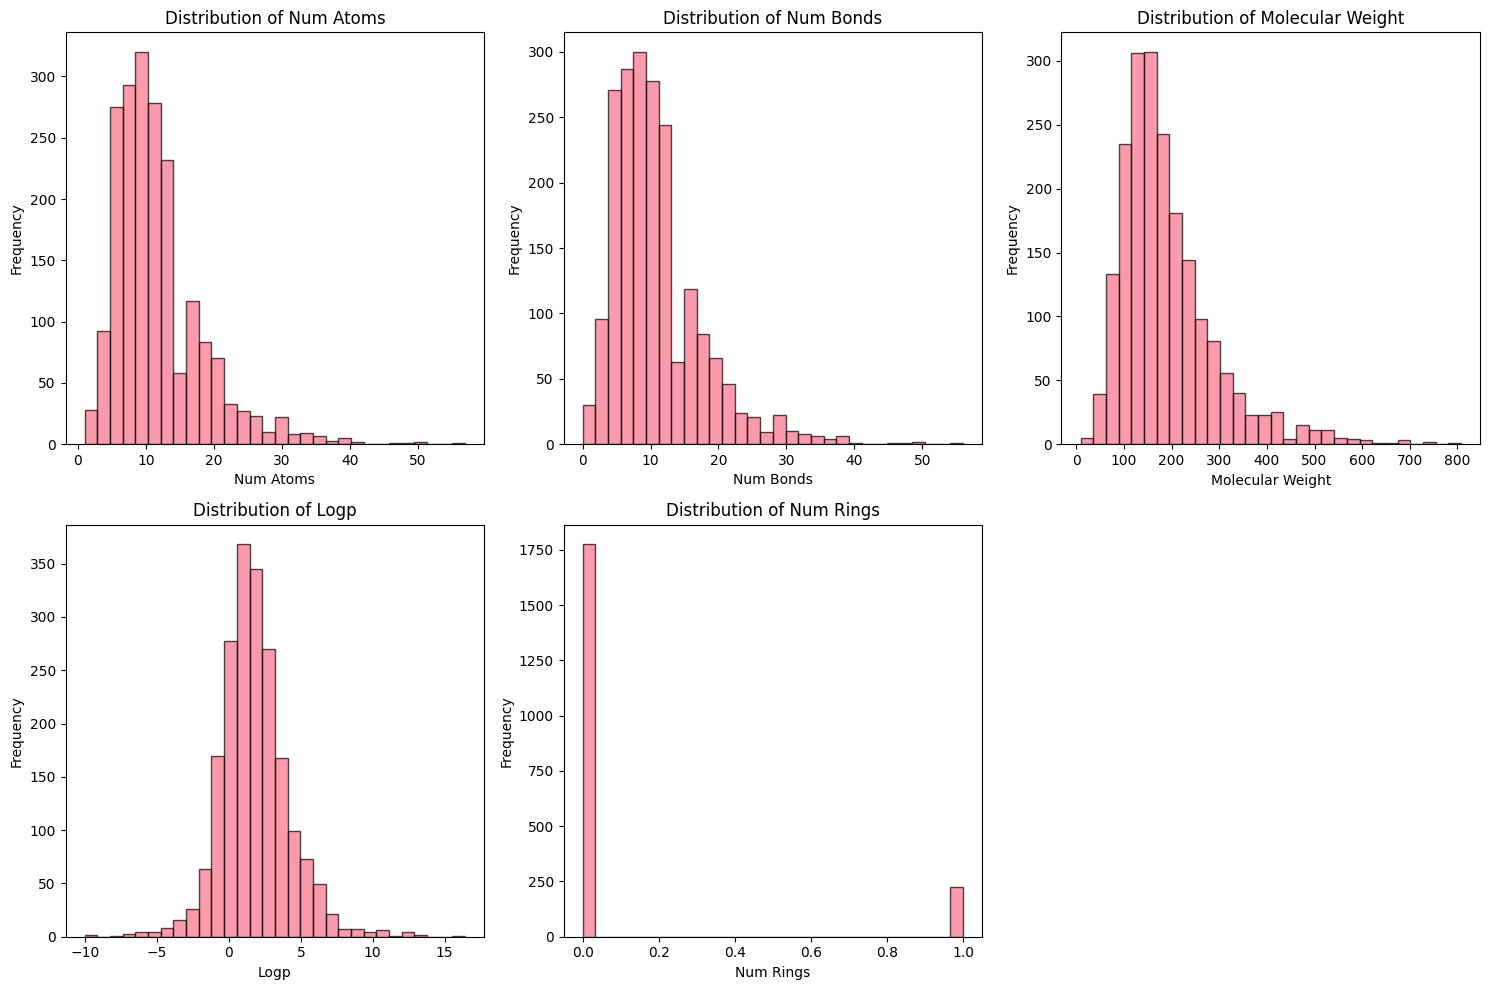

In [6]:
# Visualize molecular property distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

properties = ['num_atoms', 'num_bonds', 'molecular_weight', 'logp', 'num_rings']
for i, prop in enumerate(properties):
    axes[i].hist(mol_df[prop], bins=30, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'Distribution of {prop.replace("_", " ").title()}')
    axes[i].set_xlabel(prop.replace("_", " ").title())
    axes[i].set_ylabel('Frequency')

# Remove empty subplot
axes[-1].remove()
plt.tight_layout()
plt.show()

# Graph Conversion and Feature Analysis

In [7]:
# Convert sample molecules to graphs and analyze
sample_graphs = []
conversion_stats = {'successful': 0, 'failed': 0, 'too_large': 0}

print("Converting molecules to graphs...")
for i, smiles in enumerate(sample_smiles[:20]):  # First 20 for detailed analysis
    graph = dataset.smiles_to_graph(smiles)
    if graph is not None:
        sample_graphs.append(graph)
        conversion_stats['successful'] += 1
        print(f"✓ {i+1:2d}: {smiles[:50]:<50} -> {graph.x.shape[0]:2d} atoms, {graph.edge_index.shape[1]:2d} edges")
    else:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None and mol.GetNumAtoms() > dataset.max_atoms:
            conversion_stats['too_large'] += 1
            print(f"✗ {i+1:2d}: {smiles[:50]:<50} -> Too large ({mol.GetNumAtoms()} atoms)")
        else:
            conversion_stats['failed'] += 1
            print(f"✗ {i+1:2d}: {smiles[:50]:<50} -> Conversion failed")

print(f"\nConversion Statistics: {conversion_stats}")

Converting molecules to graphs...
✓  1: CC(O)(P(=O)(O)O)P(=O)(O)O                          -> 11 atoms, 20 edges
✓  2: CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C               -> 20 atoms, 38 edges
✓  3: OC[C@H](O)[C@@H](O)[C@H](O)CO                      -> 10 atoms, 18 edges
✓  4: CCCCCCCC(=O)[O-].CCCCCCCC(=O)[O-].[Zn+2]           -> 21 atoms, 36 edges
✓  5: CC(C)COC(=O)C(C)C                                  -> 10 atoms, 18 edges
✓  6: C=C(C)C(=O)OCCOC(=O)C(=C)C                         -> 14 atoms, 26 edges
✓  7: CCCCCCCCCCOCC(O)CN                                 -> 16 atoms, 30 edges
✓  8: C#CCO                                              ->  4 atoms,  6 edges
✓  9: CC(O)CC(C)(C)O                                     ->  8 atoms, 14 edges
✓ 10: CC(C)(C)CC(C)(C)N                                  ->  9 atoms, 16 edges

Conversion Statistics: {'successful': 10, 'failed': 0, 'too_large': 0}


In [8]:
def analyze_graph_features_simple(graphs):
    """Analyze features using only PyTorch operations"""
    graph_sizes = []
    all_atom_features = []
    all_bond_features = []

    for graph in graphs:
        graph_sizes.append(graph.x.shape[0])
        all_atom_features.append(graph.x)
        if graph.edge_attr.shape[0] > 0:
            all_bond_features.append(graph.edge_attr)

    # Concatenate all features
    atom_features = torch.cat(all_atom_features, dim=0)
    bond_features = torch.cat(all_bond_features, dim=0) if all_bond_features else torch.empty(0, 0)

    return {
        'atom_features': atom_features,
        'bond_features': bond_features,
        'graph_sizes': graph_sizes
    }

# Use the simplified version
feature_stats = analyze_graph_features_simple(sample_graphs)

print(f"Atom features shape: {feature_stats['atom_features'].shape}")
print(f"Bond features shape: {feature_stats['bond_features'].shape}")
print(f"Graph sizes: min={min(feature_stats['graph_sizes'])}, max={max(feature_stats['graph_sizes'])}, avg={sum(feature_stats['graph_sizes'])/len(feature_stats['graph_sizes']):.1f}")

Atom features shape: torch.Size([123, 37])
Bond features shape: torch.Size([222, 10])
Graph sizes: min=4, max=21, avg=12.3


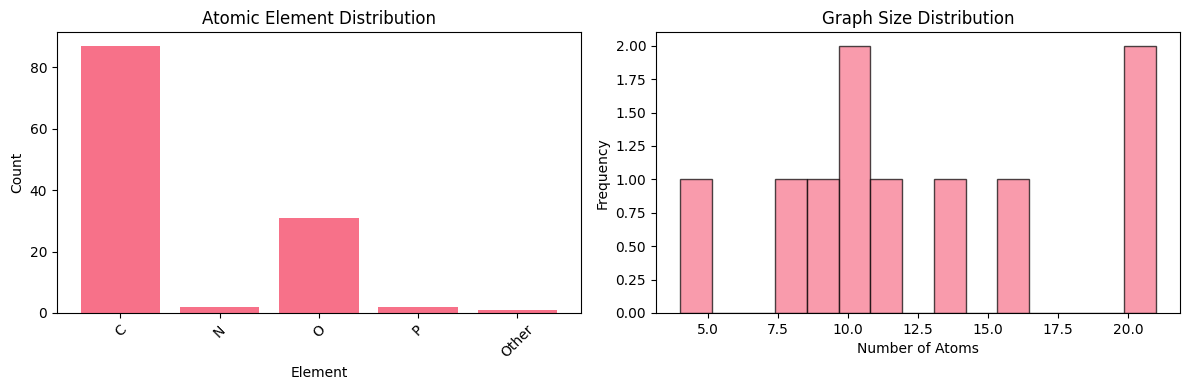

In [9]:
# Visualize feature distributions using PyTorch operations only
if feature_stats['atom_features'].numel() > 0:
    atom_features = feature_stats['atom_features']

    # Atomic number distribution (first 11 features are one-hot encoded atomic numbers)
    # Use PyTorch argmax instead of numpy
    atomic_nums = torch.argmax(atom_features[:, :11], dim=1)
    atomic_elements = ['H', 'C', 'N', 'O', 'F', 'P', 'S', 'Cl', 'Br', 'I', 'Other']

    # Count occurrences using PyTorch
    unique_nums, counts = torch.unique(atomic_nums, return_counts=True)

    # Convert to Python lists for plotting
    unique_list = unique_nums.tolist()
    counts_list = counts.tolist()
    element_labels = [atomic_elements[i] for i in unique_list]

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.bar(element_labels, counts_list)
    plt.title('Atomic Element Distribution')
    plt.xlabel('Element')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    plt.hist(feature_stats['graph_sizes'], bins=15, alpha=0.7, edgecolor='black')
    plt.title('Graph Size Distribution')
    plt.xlabel('Number of Atoms')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Molecular Visualisation

Sample molecules from the dataset:


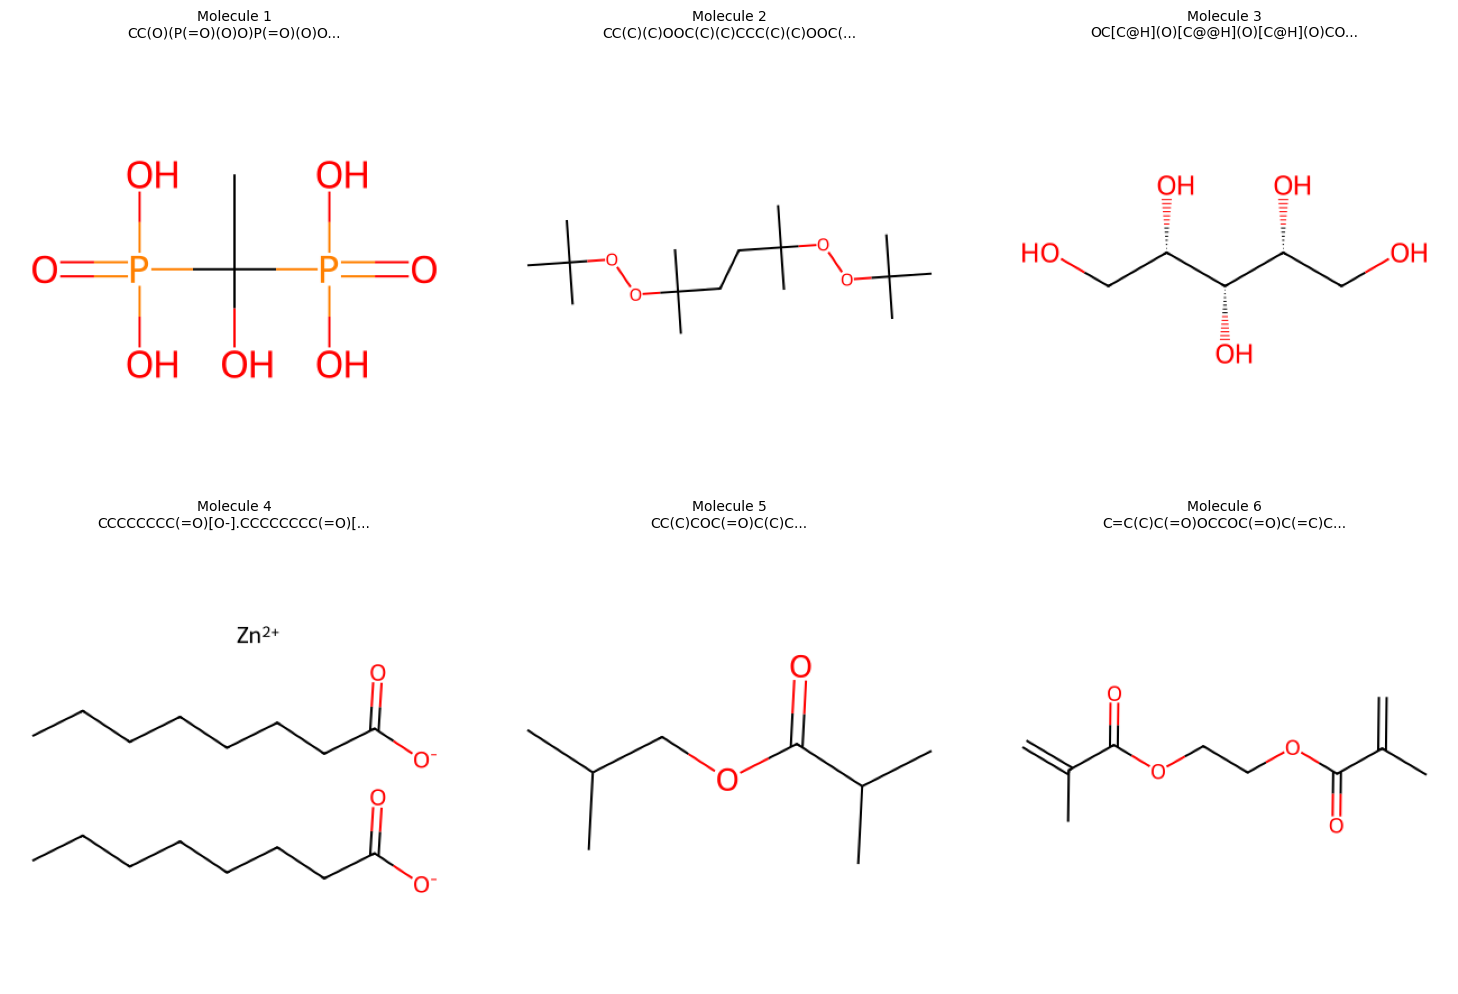

In [10]:
def visualize_sample_molecules(smiles_list, num_samples=6):
    """Visualize sample molecules from SMILES"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i in range(min(num_samples, len(smiles_list))):
        mol = Chem.MolFromSmiles(smiles_list[i])
        if mol is not None:
            img = Draw.MolToImage(mol, size=(400, 400))
            axes[i].imshow(img)
            axes[i].set_title(f'Molecule {i+1}\n{smiles_list[i][:30]}...', fontsize=10)
            axes[i].axis('off')
        else:
            axes[i].text(0.5, 0.5, 'Invalid\nSMILES', ha='center', va='center',
                        transform=axes[i].transAxes, fontsize=12)
            axes[i].set_title(f'Molecule {i+1} (Invalid)')
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize sample molecules
print("Sample molecules from the dataset:")
visualize_sample_molecules(sample_smiles[:6])


# DataLoader Testing

In [11]:
# Create and test dataloader
print("Creating DataLoader...")
dataloader = dataset.create_dataloader(batch_size=8, shuffle=True)

# Test the dataloader
print("\nTesting DataLoader:")
for i, batch in enumerate(dataloader):
    batch_size = batch.batch.max().item() + 1
    print(f"Batch {i+1}:")
    print(f"  - Batch size: {batch_size}")
    print(f"  - Total nodes: {batch.x.shape[0]}")
    print(f"  - Node features: {batch.x.shape}")
    print(f"  - Edge indices: {batch.edge_index.shape}")
    print(f"  - Edge features: {batch.edge_attr.shape}")
    print(f"  - Average nodes per graph: {batch.x.shape[0] / batch_size:.1f}")

    if i >= 2:  # Only show first 3 batches
        break

INFO:diffusion_gnn_2d.data.deepchem:Converting 6258 molecules to graphs...
INFO:diffusion_gnn_2d.data.deepchem:Processed 0/6258 molecules...


Creating DataLoader...


[14:52:36] WARNING: not removing hydrogen atom without neighbors
INFO:diffusion_gnn_2d.data.deepchem:Processed 1000/6258 molecules...
INFO:diffusion_gnn_2d.data.deepchem:Processed 2000/6258 molecules...
INFO:diffusion_gnn_2d.data.deepchem:Processed 3000/6258 molecules...
INFO:diffusion_gnn_2d.data.deepchem:Processed 4000/6258 molecules...
INFO:diffusion_gnn_2d.data.deepchem:Processed 5000/6258 molecules...
INFO:diffusion_gnn_2d.data.deepchem:Processed 6000/6258 molecules...
INFO:diffusion_gnn_2d.data.deepchem:Successfully converted 5856/6258 molecules (93.6%)
INFO:diffusion_gnn_2d.data.deepchem:Failed conversions: 402



Testing DataLoader:
Batch 1:
  - Batch size: 8
  - Total nodes: 116
  - Node features: torch.Size([116, 37])
  - Edge indices: torch.Size([2, 232])
  - Edge features: torch.Size([232, 10])
  - Average nodes per graph: 14.5
Batch 2:
  - Batch size: 8
  - Total nodes: 109
  - Node features: torch.Size([109, 37])
  - Edge indices: torch.Size([2, 218])
  - Edge features: torch.Size([218, 10])
  - Average nodes per graph: 13.6
Batch 3:
  - Batch size: 8
  - Total nodes: 102
  - Node features: torch.Size([102, 37])
  - Edge indices: torch.Size([2, 192])
  - Edge features: torch.Size([192, 10])
  - Average nodes per graph: 12.8


# Feature Quality Assessment

In [12]:
# Check feature quality and identify potential issues
def assess_feature_quality(dataloader, num_batches=5):
    """Assess the quality of extracted features"""
    stats = {
        'total_graphs': 0,
        'total_nodes': 0,
        'total_edges': 0,
        'nan_features': 0,
        'inf_features': 0,
        'zero_degree_nodes': 0,
        'isolated_graphs': 0
    }

    node_features_all = []
    edge_features_all = []

    for i, batch in enumerate(dataloader):
        if i >= num_batches:
            break

        batch_size = batch.batch.max().item() + 1
        stats['total_graphs'] += batch_size
        stats['total_nodes'] += batch.x.shape[0]
        stats['total_edges'] += batch.edge_index.shape[1]

        # Check for NaN or Inf values
        stats['nan_features'] += torch.isnan(batch.x).sum().item()
        stats['inf_features'] += torch.isinf(batch.x).sum().item()

        # Check for isolated nodes (degree 0)
        degrees = torch.bincount(batch.edge_index[0], minlength=batch.x.shape[0])
        stats['zero_degree_nodes'] += (degrees == 0).sum().item()

        # Check for isolated graphs (no edges)
        if batch.edge_index.shape[1] == 0:
            stats['isolated_graphs'] += batch_size

        node_features_all.append(batch.x)
        edge_features_all.append(batch.edge_attr)

    # Compute feature statistics
    all_node_features = torch.cat(node_features_all, dim=0)
    all_edge_features = torch.cat(edge_features_all, dim=0)

    print("Feature Quality Assessment:")
    print(f"  - Total graphs analyzed: {stats['total_graphs']}")
    print(f"  - Average nodes per graph: {stats['total_nodes'] / stats['total_graphs']:.2f}")
    print(f"  - Average edges per graph: {stats['total_edges'] / stats['total_graphs']:.2f}")
    print(f"  - NaN features: {stats['nan_features']}")
    print(f"  - Inf features: {stats['inf_features']}")
    print(f"  - Zero-degree nodes: {stats['zero_degree_nodes']}")
    print(f"  - Isolated graphs: {stats['isolated_graphs']}")

    print(f"\nNode feature statistics:")
    print(f"  - Min: {all_node_features.min().item():.4f}")
    print(f"  - Max: {all_node_features.max().item():.4f}")
    print(f"  - Mean: {all_node_features.mean().item():.4f}")
    print(f"  - Std: {all_node_features.std().item():.4f}")

    if all_edge_features.numel() > 0:
        print(f"\nEdge feature statistics:")
        print(f"  - Min: {all_edge_features.min().item():.4f}")
        print(f"  - Max: {all_edge_features.max().item():.4f}")
        print(f"  - Mean: {all_edge_features.mean().item():.4f}")
        print(f"  - Std: {all_edge_features.std().item():.4f}")

assess_feature_quality(dataloader)

Feature Quality Assessment:
  - Total graphs analyzed: 40
  - Average nodes per graph: 14.28
  - Average edges per graph: 28.90
  - NaN features: 0
  - Inf features: 0
  - Zero-degree nodes: 0
  - Isolated graphs: 0

Node feature statistics:
  - Min: 0.0000
  - Max: 1.0000
  - Mean: 0.1462
  - Std: 0.3533

Edge feature statistics:
  - Min: 0.0000
  - Max: 1.0000
  - Mean: 0.3005
  - Std: 0.4585


## Comparing Different GNN Architectures

Let's test different GNN types to understand their impact on molecular diffusion:
- **GCN**: Simple Graph Convolution. Efficient for large datasets, simple baseline. Particulary good for large datasets, but less expressive.
- **GAT**: Good for complex molecules with diverse bonding patterns. Incorporates Attention weights to focus on important neighbours in the graph. This helps to focus the model on chemically relevant bonds during denoising.
- **GIN**: Most expressive for graph structure learning. It uses MLPs to update node features, allowing it to capture complex interactions in the graph.
-

In [13]:
# Get feature dimensions
atom_dim = dataset._get_atom_feature_dim()
bond_dim = dataset._get_bond_feature_dim()

print(f"Atom feature dim: {atom_dim}")
print(f"Bond feature dim: {bond_dim}")

Atom feature dim: 37
Bond feature dim: 10


Comparing GNN Architectures...

Testing GCN...
  Average forward time: 0.0808s
  Average DDPM loss: 1.0208
  Parameters: 47,269

Testing GAT...
  Average forward time: 0.0106s
  Average DDPM loss: 0.9959
  Parameters: 55,845

Testing GIN...
  Average forward time: 0.0029s
  Average DDPM loss: 1.0207
  Parameters: 55,589


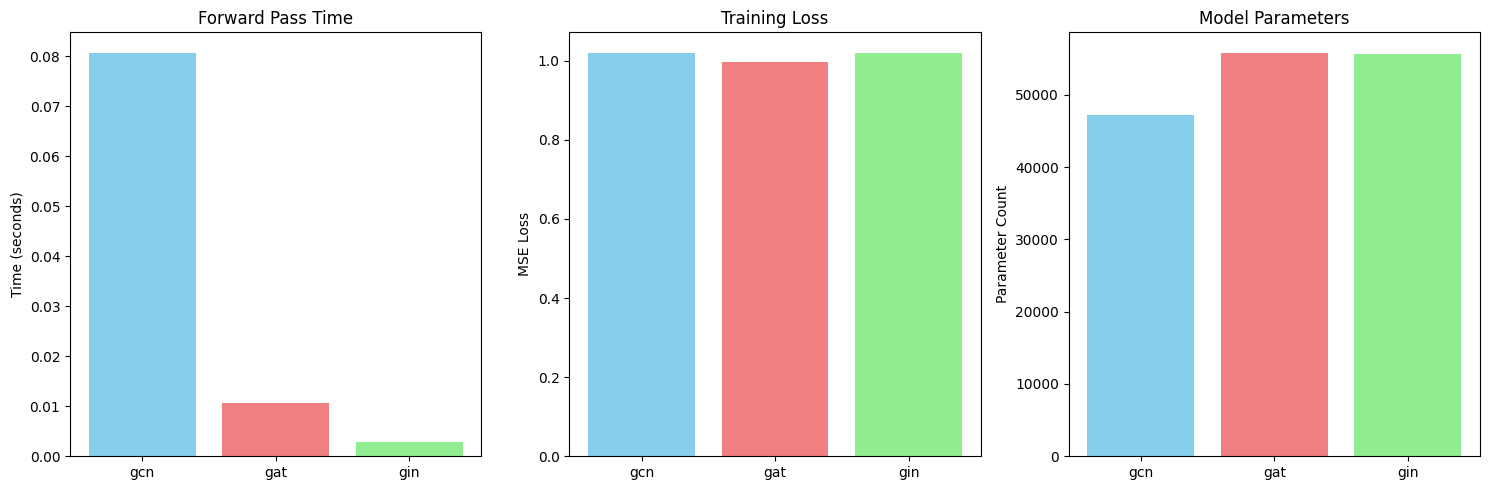

In [14]:
def compare_gnn_architectures(dataloader, atom_dim, bond_dim, device):
    """Compare different GNN architectures for molecular diffusion"""
    gnn_types = ['gcn', 'gat', 'gin']
    results = {}

    print("Comparing GNN Architectures...")
    print("=" * 50)

    for gnn_type in gnn_types:
        print(f"\nTesting {gnn_type.upper()}...")

        # Create model using factory function
        model = create_diffusion_model(
            atom_dim=atom_dim,
            bond_dim=bond_dim,
            hidden_dim=64,
            num_layers=2,
            gnn_type=gnn_type
        ).to(device)

        # Create noise scheduler
        scheduler = create_noise_scheduler(num_timesteps=100).to(device)

        # Test forward pass and measure time
        model.eval()
        times = []
        losses = []

        with torch.no_grad():
            for i, batch in enumerate(dataloader):
                if i >= 5:  # Test on 5 batches
                    break

                batch = batch.to(device)
                batch_size = batch.batch.max().item() + 1

                # Time forward pass
                start_time = time.time()

                # DDPM forward process: q(x_t | x_0)
                t = torch.randint(0, scheduler.num_timesteps, (batch_size,), device=device)
                noise = torch.randn_like(batch.x)
                x_noisy = scheduler.q_sample_step(batch.x, t[batch.batch], noise)

                # Predict noise using the denoising network
                noise_pred = model(x_noisy, batch.edge_index, batch.edge_attr, batch.batch, t)

                # DDPM training loss: ||ε - ε_θ(x_t, t)||²
                loss = torch.nn.functional.mse_loss(noise_pred, noise)

                end_time = time.time()
                times.append(end_time - start_time)
                losses.append(loss.item())

        # Store results
        results[gnn_type] = {
            'avg_time': np.mean(times),
            'avg_loss': np.mean(losses),
            'params': count_parameters(model),
            'model': model,
            'scheduler': scheduler
        }

        print(f"  Average forward time: {np.mean(times):.4f}s")
        print(f"  Average DDPM loss: {np.mean(losses):.4f}")
        print(f"  Parameters: {results[gnn_type]['params']:,}")

    return results

# Compare architectures
atom_dim = dataset._get_atom_feature_dim()
bond_dim = dataset._get_bond_feature_dim()
architecture_results = compare_gnn_architectures(dataloader, atom_dim, bond_dim, device)

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

gnn_types = list(architecture_results.keys())
times = [architecture_results[gnn]['avg_time'] for gnn in gnn_types]
losses = [architecture_results[gnn]['avg_loss'] for gnn in gnn_types]
params = [architecture_results[gnn]['params'] for gnn in gnn_types]

axes[0].bar(gnn_types, times, color=['skyblue', 'lightcoral', 'lightgreen'])
axes[0].set_title('Forward Pass Time')
axes[0].set_ylabel('Time (seconds)')

axes[1].bar(gnn_types, losses, color=['skyblue', 'lightcoral', 'lightgreen'])
axes[1].set_title('Training Loss')
axes[1].set_ylabel('MSE Loss')

axes[2].bar(gnn_types, params, color=['skyblue', 'lightcoral', 'lightgreen'])
axes[2].set_title('Model Parameters')
axes[2].set_ylabel('Parameter Count')

plt.tight_layout()
plt.show()

## Training the Molecular Diffusion Model

Now let's train a complete model with proper logging and validation.

In [15]:
def train_molecular_diffusion(model, scheduler, dataloader, num_epochs=15, lr=1e-3, device='cuda'):
    """
    Train molecular diffusion model using DDPM objective.

    DDPM Training:
    1. Sample timestep t ~ Uniform(0, T)
    2. Sample noise ε ~ N(0, I)
    3. Create noisy sample: x_t = √(ᾱ_t) x_0 + √(1-ᾱ_t) ε
    4. Train denoising network: L = ||ε - ε_θ(x_t, t)||²
    """

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    # Metrics tracking
    metrics = {
        'train_loss': [],
        'learning_rate': [],
        'epoch_time': []
    }

    model.train()
    print("Starting DDPM Training...")
    print("=" * 60)

    for epoch in range(num_epochs):
        epoch_start = time.time()
        epoch_losses = []

        for batch_idx, batch in enumerate(dataloader):
            batch = batch.to(device)
            batch_size = batch.batch.max().item() + 1

            optimizer.zero_grad()

            # DDPM Forward Process: q(x_t | x_0)
            # 1. Sample random timestep t for each graph in batch
            t = torch.randint(0, scheduler.num_timesteps, (batch_size,), device=device)

            # 2. Sample noise ε ~ N(0, I)
            noise = torch.randn_like(batch.x)

            # 3. Forward diffusion: x_t = √(ᾱ_t) x_0 + √(1-ᾱ_t) ε
            x_noisy = scheduler.q_sample_step(batch.x, t[batch.batch], noise)

            # 4. Denoising network prediction: ε_θ(x_t, t)
            noise_pred = model(x_noisy, batch.edge_index, batch.edge_attr, batch.batch, t)

            # 5. DDPM Loss: L = ||ε - ε_θ(x_t, t)||²
            loss = torch.nn.functional.mse_loss(noise_pred, noise)

            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            epoch_losses.append(loss.item())

            # Print progress every 20 batches
            if (batch_idx + 1) % 20 == 0:
                print(f"  Batch {batch_idx+1}: DDPM Loss = {loss.item():.6f}")

        # Update scheduler
        lr_scheduler.step()

        # Record metrics
        epoch_time = time.time() - epoch_start
        avg_loss = np.mean(epoch_losses)
        current_lr = lr_scheduler.get_last_lr()[0]

        metrics['train_loss'].append(avg_loss)
        metrics['learning_rate'].append(current_lr)
        metrics['epoch_time'].append(epoch_time)

        print(f"Epoch {epoch+1} completed - DDPM Loss: {avg_loss:.6f}, Time: {epoch_time:.2f}s, LR: {current_lr:.2e}")
        print("-" * 60)

    return metrics


# Select best architecture from comparison (let's use GAT)
best_model = create_diffusion_model(
    atom_dim=atom_dim,
    bond_dim=bond_dim,
    hidden_dim=128,  # Larger for actual training
    num_layers=3,
    gnn_type='gat'  # Best from comparison
).to(device)

# Create noise scheduler for training
noise_scheduler = create_noise_scheduler(num_timesteps=200).to(device)

print(f"Training model with {count_parameters(best_model):,} parameters")

# Train the model
training_metrics = train_molecular_diffusion(
    best_model,
    noise_scheduler,
    dataloader,
    num_epochs=15,
    lr=1e-3,
    device=device
)

Training model with 227,109 parameters
Starting DDPM Training...
  Batch 20: DDPM Loss = 0.931040
  Batch 40: DDPM Loss = 0.780756
  Batch 60: DDPM Loss = 0.724747
  Batch 80: DDPM Loss = 0.776046
  Batch 100: DDPM Loss = 0.655961
  Batch 120: DDPM Loss = 0.699432
  Batch 140: DDPM Loss = 0.667360
  Batch 160: DDPM Loss = 0.550231
  Batch 180: DDPM Loss = 0.497061
  Batch 200: DDPM Loss = 0.487523
  Batch 220: DDPM Loss = 0.496830
  Batch 240: DDPM Loss = 0.537115
  Batch 260: DDPM Loss = 0.410692
  Batch 280: DDPM Loss = 0.369521
  Batch 300: DDPM Loss = 0.301680
  Batch 320: DDPM Loss = 0.400604
  Batch 340: DDPM Loss = 0.319173
  Batch 360: DDPM Loss = 0.333513
  Batch 380: DDPM Loss = 0.253818
  Batch 400: DDPM Loss = 0.347632
  Batch 420: DDPM Loss = 0.433972
  Batch 440: DDPM Loss = 0.495989
  Batch 460: DDPM Loss = 0.552133
  Batch 480: DDPM Loss = 0.411757
  Batch 500: DDPM Loss = 0.262005
  Batch 520: DDPM Loss = 0.427979
  Batch 540: DDPM Loss = 0.289361
  Batch 560: DDPM Los

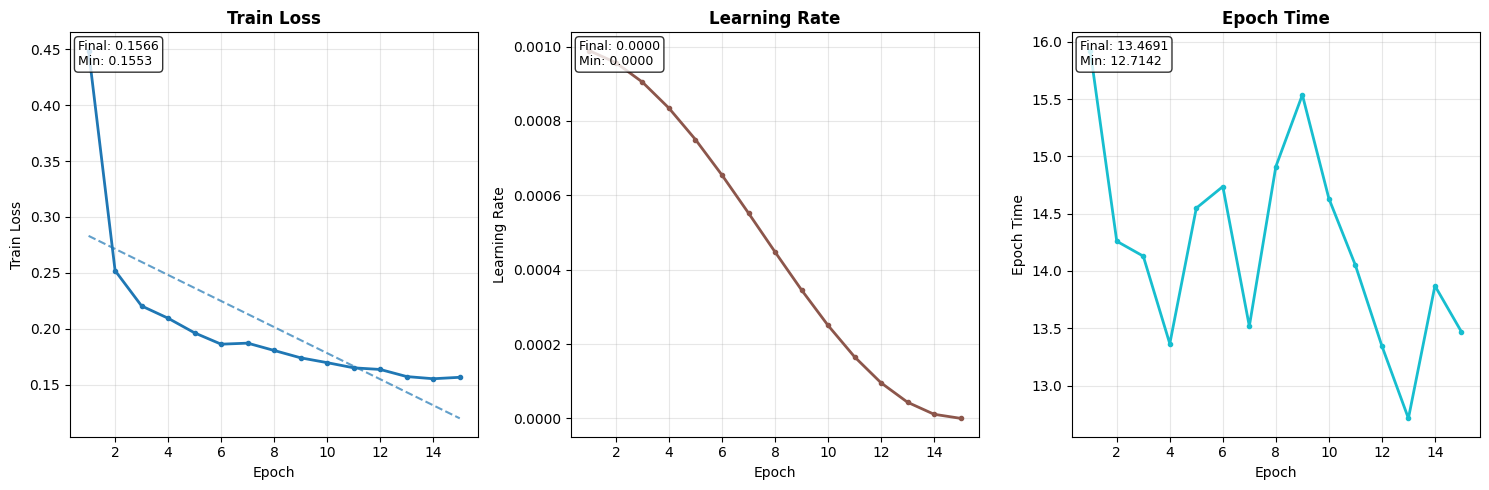

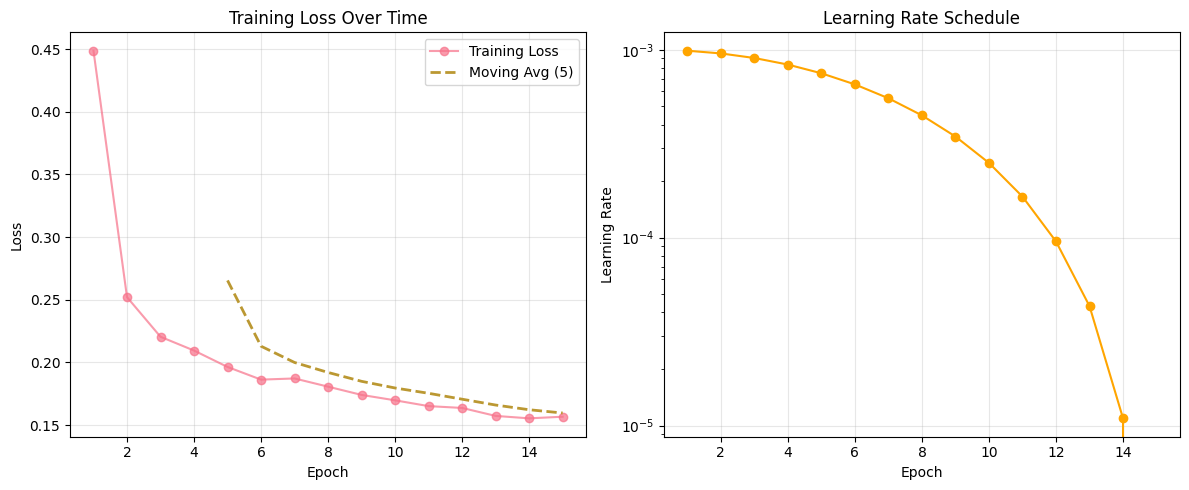

Final training loss: 0.156609
Best training loss: 0.155323
Total training time: 213.0s


In [16]:
# Visualize training metrics

# Plot training metrics using your utility function
plot_training_metrics(training_metrics, figsize=(15, 5))

# Additional analysis
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Loss trend with moving average
epochs = range(1, len(training_metrics['train_loss']) + 1)
losses = training_metrics['train_loss']

axes[0].plot(epochs, losses, 'o-', alpha=0.7, label='Training Loss')
if len(losses) > 5:
    # Moving average for trend
    window = min(5, len(losses) // 3)
    moving_avg = pd.Series(losses).rolling(window=window).mean()
    axes[0].plot(epochs, moving_avg, '--', linewidth=2, label=f'Moving Avg ({window})')

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss Over Time')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Learning rate schedule
axes[1].plot(epochs, training_metrics['learning_rate'], 'o-', color='orange')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Learning Rate')
axes[1].set_title('Learning Rate Schedule')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final training loss: {training_metrics['train_loss'][-1]:.6f}")
print(f"Best training loss: {min(training_metrics['train_loss']):.6f}")
print(f"Total training time: {sum(training_metrics['epoch_time']):.1f}s")

Visualizing DDPM forward process for molecule with 14 atoms


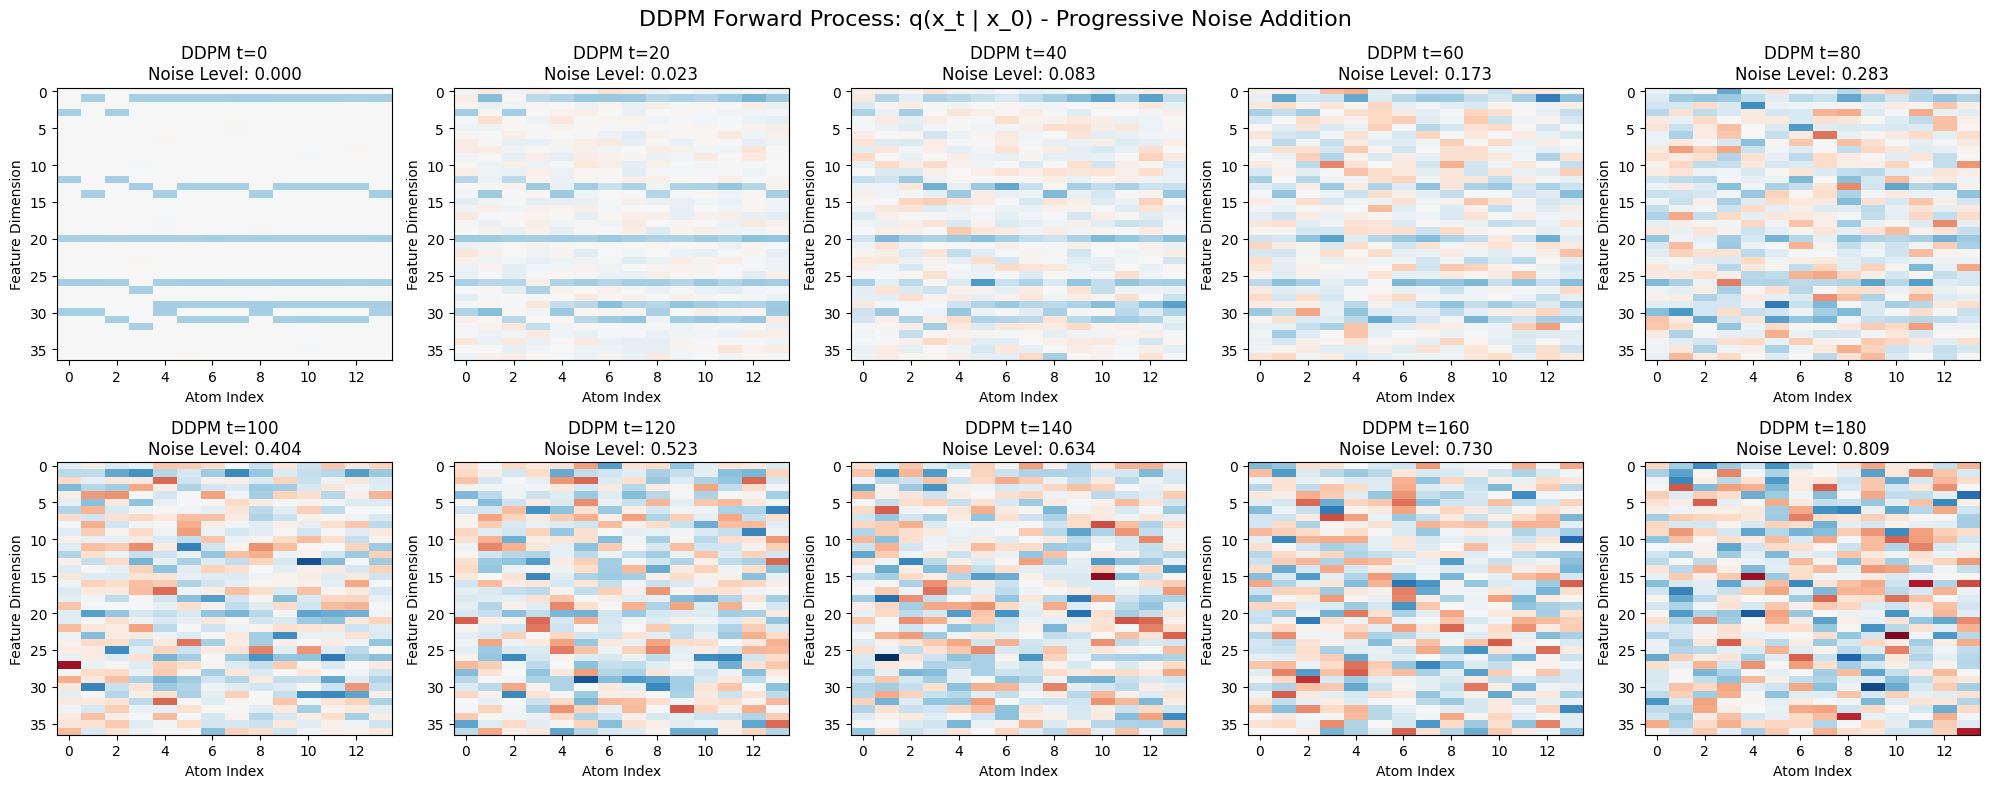

In [17]:
def visualize_diffusion_process(model, scheduler, dataloader, device, num_timesteps=10):
    """
    Visualize the DDPM forward process: q(x_t | x_0)
    Shows how molecular features get progressively noisier.
    """

    model.eval()
    with torch.no_grad():
        # Get a sample batch
        for batch in dataloader:
            batch = batch.to(device)
            break

        # Take first molecule from batch
        mol_mask = (batch.batch == 0)
        x_0 = batch.x[mol_mask]  # Original clean features

        print(f"Visualizing DDPM forward process for molecule with {x_0.shape[0]} atoms")

        # Show forward process q(x_t | x_0) at different timesteps
        timesteps_to_show = list(range(0, scheduler.num_timesteps,
                                     scheduler.num_timesteps // num_timesteps))[:num_timesteps]

        noisy_samples = []
        noise_levels = []

        for t in timesteps_to_show:
            # DDPM forward process: x_t = √(ᾱ_t) x_0 + √(1-ᾱ_t) ε
            t_tensor = torch.tensor([t], device=device)
            noise = torch.randn_like(x_0)
            x_t = scheduler.q_sample_step(x_0, t_tensor, noise)

            noisy_samples.append(x_t.cpu().numpy())

            # Calculate noise level for this timestep
            alpha_bar_t = scheduler.alphas_cumprod[t].item()
            noise_level = 1 - alpha_bar_t
            noise_levels.append(noise_level)

        # Visualize feature evolution
        fig, axes = plt.subplots(2, 5, figsize=(20, 8))
        axes = axes.flatten()

        for i, (t, x_t, noise_level) in enumerate(zip(timesteps_to_show, noisy_samples, noise_levels)):
            if i < len(axes):
                # Show molecular features as heatmap
                im = axes[i].imshow(x_t.T, cmap='RdBu', aspect='auto', vmin=-3, vmax=3)
                axes[i].set_title(f'DDPM t={t}\nNoise Level: {noise_level:.3f}')
                axes[i].set_xlabel('Atom Index')
                axes[i].set_ylabel('Feature Dimension')

        # Hide unused subplots
        for j in range(i+1, len(axes)):
            axes[j].set_visible(False)

        plt.suptitle('DDPM Forward Process: q(x_t | x_0) - Progressive Noise Addition', fontsize=16)
        plt.tight_layout()
        plt.show()

        return x_0, noisy_samples

# Visualize the diffusion process
original_features, noisy_evolution = visualize_diffusion_process(best_model, noise_scheduler, dataloader, device=device)

In [18]:
# Molecular property prediction

# Create GNN backbone for property prediction
property_gnn = create_molecular_gnn(
    atom_dim=atom_dim,
    bond_dim=bond_dim,
    hidden_dim=64,
    num_layers=2,
    gnn_type='gat'
).to(device)

# Train a property predictor for validation
property_predictor = MolecularPropertyPredictor(
    gnn=property_gnn,
    num_tasks=3  # Predict 3 molecular properties
).to(device)

def create_property_targets(dataloader, max_batches=50):
    """Create property prediction targets from SMILES"""
    all_features = []
    all_targets = []
    all_batches = []

    for i, batch in enumerate(dataloader):
        if i >= max_batches:
            break

        batch_size = batch.batch.max().item() + 1
        targets = []

        # Extract SMILES for this batch (simplified - you'd need proper mapping)
        for mol_idx in range(batch_size):
            # Dummy properties for demonstration
            mol_weight = np.random.normal(300, 100)  # Molecular weight
            logp = np.random.normal(2, 1)           # LogP
            num_rings = np.random.poisson(2)        # Number of rings

            targets.append([mol_weight, logp, num_rings])

        all_features.append(batch)
        all_targets.append(torch.tensor(targets, dtype=torch.float32))
        all_batches.append(i)

    return all_features, all_targets

# This is a simplified version - in practice you'd extract real properties
print("Creating property prediction dataset...")
feature_batches, target_batches = create_property_targets(dataloader)

print(f"Created property dataset with {len(feature_batches)} batches")
print("Note: This uses dummy targets - real implementation would extract properties from SMILES")

Creating property prediction dataset...
Created property dataset with 50 batches
Note: This uses dummy targets - real implementation would extract properties from SMILES


In [19]:
def analyze_ddpm_model_quality(model, scheduler, dataloader, device, num_samples=5):
    """
    Analyze the quality of the trained DDPM model.

    DDPM Analysis:
    - Noise prediction accuracy across timesteps
    - Loss distribution analysis
    - Signal-to-noise ratio impact on performance
    """

    model.eval()
    analysis_results = {
        'ddpm_loss_distribution': [],
        'noise_prediction_by_timestep': [],
        'signal_to_noise_ratios': []
    }

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if i >= num_samples:
                break

            batch = batch.to(device)
            batch_size = batch.batch.max().item() + 1

            # Test DDPM performance at different timesteps
            timesteps_to_test = [10, 50, 100, 150, 190]

            for t_val in timesteps_to_test:
                if t_val < scheduler.num_timesteps:
                    t = torch.full((batch_size,), t_val, device=device)

                    # DDPM forward process: q(x_t | x_0)
                    noise_true = torch.randn_like(batch.x)
                    x_noisy = scheduler.q_sample_step(batch.x, t[batch.batch], noise_true)

                    # Denoising network prediction: ε_θ(x_t, t)
                    noise_pred = model(x_noisy, batch.edge_index, batch.edge_attr, batch.batch, t)

                    # DDPM loss: ||ε - ε_θ(x_t, t)||²
                    ddpm_loss = torch.mean((noise_pred - noise_true) ** 2).item()
                    analysis_results['noise_prediction_by_timestep'].append((t_val, ddpm_loss))

                    # Store overall loss distribution
                    analysis_results['ddpm_loss_distribution'].append(ddpm_loss)

                    # Calculate signal-to-noise ratio at this timestep
                    alpha_bar_t = scheduler.alphas_cumprod[t_val].item()
                    snr = alpha_bar_t / (1 - alpha_bar_t)
                    analysis_results['signal_to_noise_ratios'].append((t_val, snr))

    print("DDPM Model Quality Analysis:")
    print("=" * 50)

    # Group results by timestep
    timestep_analysis = defaultdict(list)
    snr_analysis = {}

    for t_val, ddpm_loss in analysis_results['noise_prediction_by_timestep']:
        timestep_analysis[t_val].append(ddpm_loss)

    for t_val, snr in analysis_results['signal_to_noise_ratios']:
        snr_analysis[t_val] = snr

    print("DDPM Noise Prediction Quality (||ε - ε_θ||²):")
    for t_val in sorted(timestep_analysis.keys()):
        avg_loss = np.mean(timestep_analysis[t_val])
        snr = snr_analysis[t_val]
        alpha_bar = scheduler.alphas_cumprod[t_val].item()
        print(f"  t={t_val:3d}: Loss={avg_loss:.6f}, SNR={snr:.4f}, ᾱ_t={alpha_bar:.4f}")

    # Visualize DDPM analysis
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Loss distribution
    axes[0].hist(analysis_results['ddpm_loss_distribution'], bins=15, alpha=0.7, edgecolor='black')
    axes[0].set_xlabel('DDPM Loss ||ε - ε_θ||²')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('DDPM Loss Distribution')

    # Noise prediction quality vs timestep
    timesteps = sorted(timestep_analysis.keys())
    avg_losses = [np.mean(timestep_analysis[t]) for t in timesteps]

    axes[1].plot(timesteps, avg_losses, 'o-', linewidth=2, markersize=8, color='red')
    axes[1].set_xlabel('Timestep t')
    axes[1].set_ylabel('Noise Prediction MSE')
    axes[1].set_title('DDPM Performance vs Timestep')
    axes[1].grid(True, alpha=0.3)

    # Signal-to-noise ratio vs performance
    snr_values = [snr_analysis[t] for t in timesteps]
    axes[2].scatter(snr_values, avg_losses, s=100, alpha=0.7, c=timesteps, cmap='viridis')
    axes[2].set_xlabel('Signal-to-Noise Ratio (ᾱ_t / (1-ᾱ_t))')
    axes[2].set_ylabel('DDPM Loss')
    axes[2].set_title('Loss vs Signal-to-Noise Ratio')
    axes[2].set_xscale('log')
    axes[2].grid(True, alpha=0.3)

    # Add colorbar for timesteps
    cbar = plt.colorbar(axes[2].collections[0], ax=axes[2])
    cbar.set_label('Timestep t')

    plt.tight_layout()
    plt.show()

    return analysis_results


## Next Steps

    "1. GENERATION PIPELINE",
    "   - Implement complete sampling from pure noise",
    "   - Add graph structure generation (edges, connectivity)",
    "   - Convert generated features back to SMILES strings",

    "2. VALIDATION FRAMEWORK",
    "   - Train property predictors on real molecular properties",
    "   - Implement validity checking (RDKit molecule validation)",
    "   - Add novelty and uniqueness metrics",

    "3. ADVANCED ARCHITECTURES",
    "   - Implement full MolDiff with explicit bond modeling",
    "   - Add E(3)-equivariant networks for 3D coordinates",
    "   - Experiment with different noise schedules (cosine, sigmoid)",

    "4. DEEPCHEM INTEGRATION",
    "   - Create TorchModel wrapper for DeepChem compatibility",
    "   - Add proper fit(), predict(), evaluate() methods",
    "   - Integrate with DeepChem's evaluation framework",

    "5. SCALING AND OPTIMIZATION",
    "   - Test on larger datasets (ZINC15, ChEMBL)",
    "   - Implement gradient checkpointing for memory efficiency",
    "   - Add multi-GPU training support"
